In [1]:
import os

#add the root directory
os.chdir('../')

<h2> Supplementary material: f-PV manifolds parametrized by the heuristic and optimized PV

In [2]:
import numpy as np
import pandas as pd
import torch
from loader import *
import matplotlib.pyplot as plt
import h5py
import matplotlib.ticker as ticker
import matplotlib.cm as cm
import matplotlib.patches as patches
from matplotlib.gridspec import GridSpec
from matplotlib.patches import ConnectionPatch
import matplotlib.transforms as mtransforms
from matplotlib.lines import Line2D
from matplotlib.ticker import FuncFormatter, ScalarFormatter
from matplotlib.ticker import MaxNLocator
from utils import *
from PCAfold import normalized_variance_derivative, cost_function_normalized_variance_derivative
import matplotlib.lines as mlines
import matplotlib.gridspec as gridspec

logging.disable(logging.CRITICAL)

In [3]:
filename_autoignition = "isochoric-adiabatic-closed-HR-H2-air-lin_Z_0.015_0.035_100-T0_900-"
path_data_autoignition = "data-files/autoignition/"
path_data = "data-files/"

#create all the datasets
mixture_fractions_train = np.loadtxt(f"{path_data_autoignition}{filename_autoignition}mixture-fraction.csv") #1 x nbr_timesteps
mixture_fractions_test = np.loadtxt(f"{path_data_autoignition}{filename_autoignition}mixture-fractions-test-trajectories.csv") #1 x nbr_test_trajectories
state_space_names = np.genfromtxt(f"{path_data_autoignition}{filename_autoignition}state-space-names.csv", delimiter=",", dtype=str)
state_space_train = pd.read_csv(f"{path_data_autoignition}{filename_autoignition}state-space.csv", names = state_space_names)
state_space_source_train = pd.read_csv(f"{path_data_autoignition}{filename_autoignition}state-space-sources.csv", names = state_space_names)
time_train = np.loadtxt(f"{path_data_autoignition}{filename_autoignition}time.csv") #1 x nbr_timesteps

## Optimized PV

In [4]:
filename_model = "Xu-AE-opt_adam-epo_100000-lr_0.025-date_24Mar2025-hour_10h50_Tr0D-2s_s2"

filename_metadata = filename_model + "_metadata.pkl"
path_metadata = "metadata/"
filename_species_names = "Xu-state-space-names.csv"
path_data = "data-files/"

loader = loadData(filename_species_names, path_metadata, filename_metadata)
idx_species_removed = loader.metadata["list idx species removed source"] if loader.metadata["dataset_type"].startswith("autoignition_augm") else loader.metadata["idx species removed"]
id_model = loader.metadata["Training_id"]
model = loader.loadModel()

weight_inversion = False
if(weight_inversion):
    with torch.no_grad():  # Ensures we do not track gradients for this operation
        model.encoder_species.weight.mul_(-1)

state_space_names_DNS = np.genfromtxt(f"{path_data}Xu-state-space-names.csv", delimiter=",", dtype=str)

#create a np array in the format for the DNS dataset/optimized PV
state_space_train_DNS = state_space_train[state_space_names_DNS].to_numpy()
state_space_source_train_DNS = state_space_source_train[state_space_names_DNS].to_numpy()
print(state_space_source_train_DNS.shape)

PV_optimized_train = model.get_PV(torch.from_numpy(np.delete(state_space_train_DNS, idx_species_removed, axis=1))).detach().numpy()
PV_optimized_min_train = PV_optimized_train.min()
PV_optimized_max_train = PV_optimized_train.max()
PV_optimized_train_scaled = (PV_optimized_train - PV_optimized_min_train)/(PV_optimized_max_train - PV_optimized_min_train)
f_PV_optimized_train = np.hstack((mixture_fractions_train.reshape(-1,1), PV_optimized_train.reshape(-1,1)))
f_PV_optimized_train_scaled = np.hstack((mixture_fractions_train.reshape(-1,1), PV_optimized_train_scaled.reshape(-1,1)))
PV_optimized_source_train = model.get_PV(torch.from_numpy(np.delete(state_space_source_train_DNS, idx_species_removed, axis=1))).detach().numpy()

(241519, 21)


## Heuristic PV

In [5]:
PV_Xu_train = state_space_train["H2O"] - state_space_train["H2"] - state_space_train["O2"]
PV_Xu_train = PV_Xu_train.to_numpy().reshape(-1,1)

PV_Xu_train_source = state_space_source_train["H2O"] - state_space_source_train["H2"] - state_space_source_train["O2"]
PV_Xu_train_source = PV_Xu_train_source.to_numpy().reshape(-1,1)

Output_species = ['H2O2', 'H2O', 'H2', 'HO2', 'N2O', 'NO2', 'NO', 'O2', 'OH']

output_matrix = state_space_train[Output_species].to_numpy()

<h2> Overview manifolds for all the species

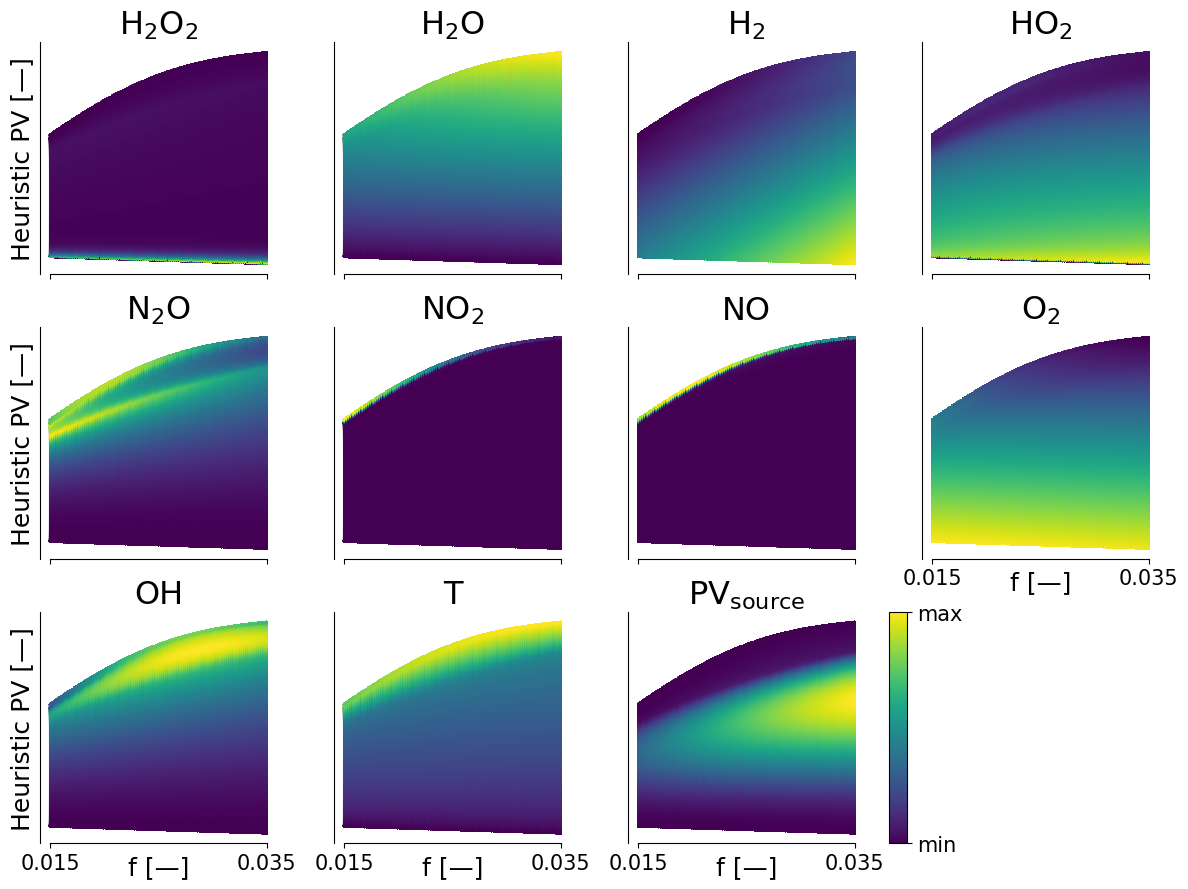

In [7]:
rows, cols = 3,4

keysSpecies = ['H2O2', 'H2O', 'H2', 'HO2', 'N2O', 'NO2', 'NO', 'O2', 'OH']
keys = ['H2O2', 'H2O', 'H2', 'HO2', 'N2O', 'NO2', 'NO', 'O2', 'OH', 'T', 'PV1']

Xu_optimized = "Xu" #'Xu' or 'Optimized'

save = True
pathSave = f"C:/Users/admin/Documents/PhD-ULB/Figures/2024-PV-optimization/Paper/EnergyAndAI/Supplementary-material/Heuristic-vs-optimized/"
name = f"f-PV manifolds - {Xu_optimized} - {id_model}.png"

fig, axes = plt.subplots(rows, cols, figsize=(12,9))  # Define the grid
axes = axes.flatten()
for i, key in enumerate(keys):
    ax = axes[i]

    if(Xu_optimized.lower() == "xu"):
         dataPV_fl = PV_Xu_train
    elif(Xu_optimized.lower() == "optimized"):
         dataPV_fl = PV_optimized_train
    else:
         raise ValueError("Variable 'Xu_optimized' has an invalid value; Choose either 'xu' or 'optimized'.")

    if(key in keysSpecies or key  == "T"):
         dataColor = state_space_train[key]
    elif(key == "PV1"):
         if(Xu_optimized.lower() == "xu"):
            dataColor = PV_Xu_train_source
         elif(Xu_optimized.lower() == "optimized"):
            dataColor = PV_optimized_source_train
         

    sc = ax.scatter(mixture_fractions_train, dataPV_fl, c = dataColor, cmap = "viridis", s=1)

    ax.set_xticks([0.015, 0.035])
    if(i>=len(keys)-cols):
        ax.tick_params(axis="x", labelsize=15)
        ax.set_xlabel("f [\u2014]", fontsize = 18, labelpad = -13)
    else:
        ax.set_xticklabels([])
    if(i%cols == 0):
        ax.set_ylabel(f'{"Optimized" if Xu_optimized.lower() == "optimized" else "Heuristic"} PV [\u2014]', fontsize = 18)
    ax.set_yticks([])
    
    key = key.replace("2", "$_{2}$").replace("1", "$_{\mathrm{source}}$")

    ax.set_title(rf"{key}", fontsize=23)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines["bottom"].set_bounds(0.015, 0.035)


for j in range(len(keys), len(axes)): #disables axes of plots not used
    axes[j].axis("off")

plt.tight_layout()

pos = axes[10].get_position()

# Define colorbar axis manually
cbar_width = 0.015   # thin bar
gap = 0.02           # small gap from subplot

cax = fig.add_axes([
    pos.x1 + gap,    # x start (right of subplot 11)
    pos.y0,          # same bottom
    cbar_width,      # width
    pos.height       # same height
])
cbar = fig.colorbar(sc, cax=cax, orientation="vertical")

vmin, vmax = sc.get_clim()

# Set ticks at the extrema
cbar.set_ticks([vmin, vmax])

# Replace numeric tick labels
cbar.set_ticklabels(["min", "max"])
cbar.ax.tick_params(labelsize=15)

handles, labels = axes[0].get_legend_handles_labels()

if(save):
        plt.savefig(f"{pathSave}{name}", dpi = 300, bbox_inches="tight")
plt.show()

## Rectangular manifold

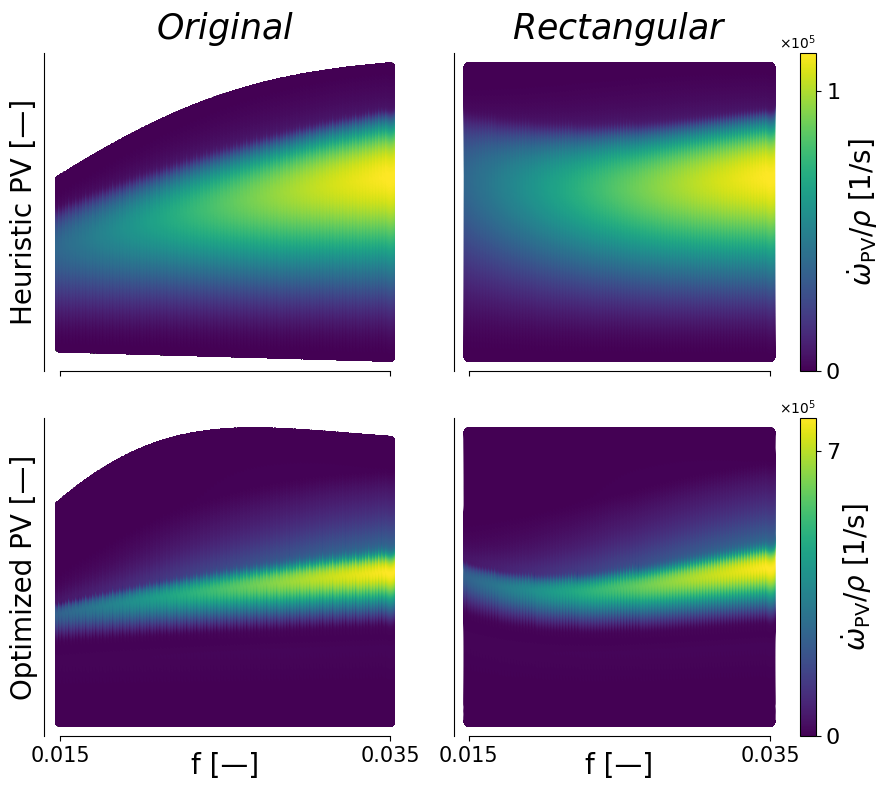

In [8]:
save = True
pathSave = "C:/Users/admin/Documents/PhD-ULB/Figures/2024-PV-optimization/Paper/EnergyAndAI/Supplementary-material/Heuristic-vs-optimized/"
name = f"f-PV - Heuristic vs optimized - Autoignition - original vs rectangular manifold.png"

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(9, 8), sharex=True)

# --- First subplot: Heuristic PV (Xu) ---
sc1 = axes[0, 0].scatter(mixture_fractions_train, PV_Xu_train, c=PV_Xu_train_source, cmap='viridis', marker='o')
axes[0, 0].set_title(r'$\mathit{Original}$', fontsize=25, pad=10)
axes[0, 0].set_ylabel('Heuristic PV [—]', fontsize=20)
axes[0, 0].set_yticks([])

# --- Second subplot: Optimized PV ---
sc2 = axes[1, 0].scatter(mixture_fractions_train, PV_optimized_train, c=PV_optimized_source_train, cmap='viridis', marker='o')
axes[1, 0].set_xlabel('f [—]', fontsize=20, labelpad = -10)
axes[1, 0].set_ylabel('Optimized PV [—]', fontsize=20)
axes[1, 0].set_yticks([])

df = pd.DataFrame({
    'PV Xu': PV_Xu_train.squeeze(),
    'mixture_fraction': mixture_fractions_train
})

# Normalize PV within each mixture_fraction group
df['PV_Xu_scaled'] = df.groupby('mixture_fraction')['PV Xu'].transform(
    lambda x: (x - x.min()) / (x.max() - x.min()) if x.max() > x.min() else 0.0
)

# Get the PV back to numpy
PV_Xu_scaled = df['PV_Xu_scaled'].to_numpy()

sc1 = axes[0, 1].scatter(mixture_fractions_train, PV_Xu_scaled, c=PV_Xu_train_source, cmap='viridis', marker='o')
axes[0, 1].set_title(r'$\mathit{Rectangular}$', fontsize=25, pad=10)
axes[0, 1].set_yticks([])

df = pd.DataFrame({
    'PV optimized': PV_optimized_train.squeeze(),
    'mixture_fraction': mixture_fractions_train
})

# Normalize PV within each mixture_fraction group
df['PV_optimized_scaled'] = df.groupby('mixture_fraction')['PV optimized'].transform(
    lambda x: (x - x.min()) / (x.max() - x.min()) if x.max() > x.min() else 0.0
)

# Get the PV back to numpy
PV_optimized_scaled = df['PV_optimized_scaled'].to_numpy()

sc2 = axes[1, 1].scatter(mixture_fractions_train, PV_optimized_scaled, c=PV_optimized_source_train, cmap='viridis', marker='o')
axes[1, 1].set_xlabel('f [—]', fontsize=20, labelpad = -10)
axes[1, 1].set_yticks([])

def custom_formatter(x, pos):
    if x == 0:
        return "0"  # Force 0 to display as an integer
    else:
        return '{:.0e}'.format(x)

class CustomScalarFormatter(ScalarFormatter):
    def __init__(self, useOffset=True, useMathText=False):
        super().__init__(useOffset=useOffset, useMathText=useMathText)

    def __call__(self, x, pos=None):
        # If the value is zero, format it as "0" instead of "0.00"
        if x == 0:
            return "0"
        else:
            return super().__call__(x, pos)

formatter1 = CustomScalarFormatter(useMathText=True)
formatter1.set_powerlimits((0, 0))

cbar1 = fig.colorbar(sc1, ax=axes[0, 1], location='right', fraction=0.046, pad=0.04)
cbar1.set_ticks([0, 100000])
cbar1.ax.tick_params(labelsize=16)
cbar1.ax.yaxis.set_major_formatter(formatter1)
cbar1.set_label(r'$\dot{\omega}_{\mathrm{PV}} / \rho$ [1/s]', fontsize=20)

# Second row colorbar
cbar2 = fig.colorbar(sc2, ax=axes[1, 1], location='right', fraction=0.046, pad=0.04)
cbar2.set_ticks([0, 700000])
cbar2.ax.tick_params(labelsize=16)
cbar2.ax.yaxis.set_major_formatter(formatter1)
cbar2.set_label(r'$\dot{\omega}_{\mathrm{PV}} / \rho$ [1/s]', fontsize=20, labelpad = 0)

# Set shared x-ticks
axes[1, 0].set_xticks([0.015, 0.035])
axes[1, 0].tick_params(axis='x', labelsize=15)

axes[1, 1].set_xticks([0.015, 0.035])
axes[1, 1].tick_params(axis='x', labelsize=15)

# Optional: Remove grid if needed
axes[0, 0].grid(False)
axes[1, 0].grid(False)

for i in range(2):
    for j in range(2):
        axes[i, j].spines['top'].set_visible(False)
        axes[i, j].spines['right'].set_visible(False)
        axes[i, j].spines["bottom"].set_bounds(0.015, 0.035)

# Adjust layout
plt.tight_layout()

# Save figure if needed
if save:
    plt.savefig(pathSave + name, dpi=300, bbox_inches='tight')

plt.show()